In [1]:
## GET TOP STOCKS THAT OUTPERFORMED SP 500.  
#Preprocessing 

from sklearn.utils import resample
import itertools
from sklearn import preprocessing
import re
from sklearn import feature_selection as f_select
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
% matplotlib inline
sns.set_style("darkgrid")
import sklearn.linear_model
import os
import math
import statsmodels.api as sm
import pylab as pl
from sklearn.metrics import roc_curve, auc
from __future__ import print_function, division
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_pickle('df.pickle')




In [3]:
df15= df[df.periodending >= '2015-12-02']
# df[df.year >= 2015]

In [4]:
len(df15)

81

In [5]:
df = df[df.periodending < '2015-12-02']

In [6]:
len(df)

941

In [7]:
X = df[['accountspayable',
       'accountsreceivable', 'addlincomeexpenseitems', 'aftertaxroe',
       'capitalexpenditures', 'capitalsurplus', 'cashratio',
       'cashandcashequivalents', 'changesininventories', 'commonstocks',
       'costofrevenue', 'currentratio', 'deferredassetcharges',
       'deferredliabilitycharges', 'depreciation',
       'earningsbeforeinterestandtax', 'earningsbeforetax',
       'effectofexchangerate', 'equityearningslossunconsolidatedsubsidiary',
       'fixedassets', 'goodwill', 'grossmargin', 'grossprofit', 'incometax',
       'intangibleassets', 'interestexpense', 'inventory', 'investments',
       'liabilities', 'longtermdebt', 'longterminvestments',
       'minorityinterest', 'miscstocks', 'netborrowings', 'netcashflow',
       'netcashflowoperating', 'netcashflowsfinancing',
       'netcashflowsinvesting', 'netincome', 'netincomeadjustments',
       'netincomeapplicabletocommonshareholders', 'netincomecontoperations',
       'netreceivables', 'nonrecurringitems', 'operatingincome',
       'operatingmargin', 'otherassets', 'othercurrentassets',
       'othercurrentliabilities', 'otherequity', 'otherfinancingactivities',
       'otherinvestingactivities', 'otherliabilities',
       'otheroperatingactivities', 'otheroperatingitems', 'pretaxmargin',
       'pretaxroe', 'profitmargin', 'quickratio', 'researchanddevelopment',
       'retainedearnings', 'saleandpurchaseofstock', 'salesgeneralandadmin',
       'shorttermdebtcurrentportionoflongtermdebt', 'shortterminvestments',
       'totalassets', 'totalcurrentassets', 'totalcurrentliabilities',
       'totalequity', 'totalliabilities', 'totalliabilitiesequity',
       'totalrevenue', 'treasurystock',  'earningspershare',
       'estimatedsharesoutstanding', 'volume',
       'housing_prices', '30year_mort', 'dis_cost',
       ]]



In [8]:
y = df.sp_class

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#join back y train to X train for full train set
train = X_train.join(y_train)

#separate train set to the two classes (my two classes are closed and operating)
outperf = train[train.sp_class == 1] 
underperf = train[train.sp_class == 0]

from sklearn.utils import resample

#upsample to 473 
outperf_up = resample(outperf, n_samples = 473, replace=True)


#add the resampled classes back together
resampled_train = pd.concat([outperf_up, underperf])

#split the resampled train into X and y
X_up= resampled_train.drop(['sp_class'], axis = 1)
y_up = resampled_train.sp_class



### Logistic Regression


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_up, y_up, test_size=0.3, random_state=42)


logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_up, y_up)
y_pred =logreg.predict(X_test)

In [23]:
print (X_up.shape, y_up.shape)
print (X_test.shape, y_test.shape)
print('Accuracy of logistic regression classifier on test set: {:.2f}'\
      .format(logreg.score(X_test, y_test)))

(917, 79) (917,)
(276, 79) (276,)
Accuracy of logistic regression classifier on test set: 0.64


In [24]:

kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression(class_weight='balanced')
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_up,
                                          y_up, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))



10-fold cross validation average accuracy: 0.650


In [25]:

from sklearn.metrics import confusion_matrix
logreg_con_mat = confusion_matrix(y_test, y_pred)
print ("Logistic Regression Confusion Matrix")
print(logreg_con_mat)


Logistic Regression Confusion Matrix
[[101  28]
 [ 72  75]]


In [26]:

len(df)

941

In [27]:


from sklearn.metrics import classification_report
print ("Logistic Regression Class Report")
print(classification_report(y_test, y_pred))


Logistic Regression Class Report
             precision    recall  f1-score   support

          0       0.58      0.78      0.67       129
          1       0.73      0.51      0.60       147

avg / total       0.66      0.64      0.63       276



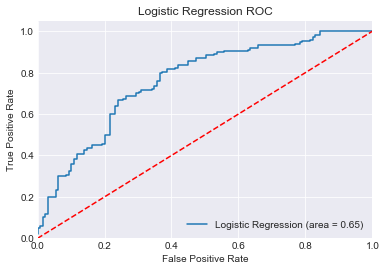

In [28]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### RANDOM FOREST 

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_model = RandomForestClassifier(max_depth= 10, min_samples_leaf=40, n_estimators= 10)
    
rf_model.fit(X_up, y_up)

predicted = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Mean accuracy score: {accuracy:.3}')
print(accuracy)

Mean accuracy score: 0.797
0.797101449275


In [30]:
len(X_up)

917

In [31]:
len(y_up)

917

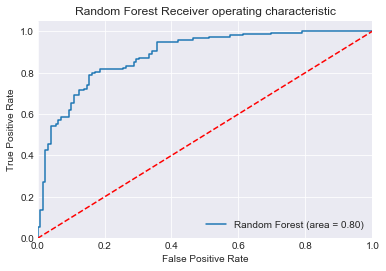

In [32]:
##Random forest 
rand_roc_auc = roc_auc_score(y_test, rf_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rand_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Random Forest_ROC')
plt.show()

In [33]:

logreg_con_mat = confusion_matrix(y_test, predicted)
print ("Random Forest Regression Confusion Matrix")
print(logreg_con_mat)

print ("Random Forest Classification Report")
print(classification_report(y_test, rfpredicted))

Random Forest Regression Confusion Matrix
[[100  29]
 [ 27 120]]
Random Forest Classification Report


NameError: name 'rfpredicted' is not defined

### AFTER GRID SEARCH {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 80}

In [34]:
{'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 50}

{'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 50}

In [41]:
##AFTER GRID SEARCH {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 80}
rf_model = RandomForestClassifier(max_depth= 25, min_samples_split=2, n_estimators= 80)
    
rf_model.fit(X_up, y_up)

rfpredicted = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, rfpredicted)

print(f'Mean accuracy score: {accuracy:.3}')
print (accuracy)

Mean accuracy score: 1.0
1.0


In [36]:

features = X.columns
feature_importances = rf_model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)
features_df.head()

,Features,Importance Score
77,30year_mort,0.048845
2,addlincomeexpenseitems,0.028851
1,accountsreceivable,0.025465
76,housing_prices,0.021544
78,dis_cost,0.020480


In [37]:
from sklearn.grid_search import GridSearchCV

rf_model= RandomForestClassifier(n_estimators = 10, max_depth = 10, min_samples_split =2) 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [5, 10, 20, 50 , 80],
           "max_depth" : [1, 5, 10, 15, 25],
           "min_samples_split" : [2, 10, 20, 40, 80]}

CV_rfc = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv= 10)
CV_rfc.fit(X_up, y_up)
print (CV_rfc.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 20}


In [38]:


train.sp_class.value_counts()

0    444
1    214
Name: sp_class, dtype: int64

In [39]:
len(df)


941

In [42]:
rf_model.predict(X_test)[0:20]

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [43]:
len(X_test)

276

In [46]:
df15['pred_prob']=[v[1] for v in rf_model.predict_proba(x15)]

In [48]:
df15.sort_values(['sp_class','pred_prob'],ascending=False).groupby('sp_class')\
.head(10)



,unnamed,ticker,periodending,accountspayable,accountsreceivable,addlincomeexpenseitems,aftertaxroe,capitalexpenditures,capitalsurplus,cashratio,...,30year_mort,sp_return,index,dis_cost,co_return,ret_vs_sp,log_co_return,return_class,sp_class,pred_prob
312,312,CHTR,2015-12-31,0.031354,0.674713,0.236832,0.101745,0.951560,0.029941,0.000000,...,0.02,0.0138,35,0.039020,0.502262,0.488462,-0.688633,1,1,0.8125
212,212,BCR,2015-12-31,0.015487,0.672309,0.220279,0.001555,0.997291,0.031252,0.078770,...,0.02,0.0138,35,0.039020,0.191842,0.178042,-1.651085,1,1,0.7250
414,414,CTXS,2015-12-31,0.005928,0.673435,0.244567,0.002764,0.995766,0.057590,0.049952,...,0.02,0.0138,35,0.039020,0.093739,0.079939,-2.367242,2,1,0.6875
90,90,ALLE,2015-12-31,0.005108,0.672780,0.239106,0.103818,0.999073,0.008123,0.043228,...,0.02,0.0138,35,0.039020,0.070410,0.056610,-2.653418,2,1,0.6500
1025,1025,MAS,2015-12-31,0.021898,0.663323,0.244250,0.045431,0.995840,0.007857,0.058598,...,0.02,0.0138,35,0.039020,0.208852,0.195052,-1.566127,1,1,0.6250
618,618,FB,2015-12-31,0.025958,0.572518,0.244250,0.001382,0.933579,0.387757,0.920269,...,0.02,0.0138,35,0.039020,0.222640,0.208840,-1.502199,1,1,0.5875
1500,1500,TAP,2015-12-31,0.018357,0.680543,0.244741,0.000864,0.992760,0.051420,0.033622,...,0.02,0.0138,35,0.039020,0.169329,0.155529,-1.775909,1,1,0.5750
1009,1009,MA,2015-12-31,0.066486,0.660293,0.241101,0.010883,0.995340,0.051459,0.124880,...,0.02,0.0138,35,0.039020,0.054384,0.040584,-2.911681,2,1,0.5000
1436,1436,SPGI,2015-12-31,0.011452,0.661860,0.244837,0.102954,0.996341,0.013030,0.048991,...,0.02,0.0138,35,0.039020,0.174694,0.160894,-1.744720,1,1,0.4625
122,122,AMZN,2015-12-31,0.506560,0.490805,0.233257,0.000691,0.879189,0.153714,0.055716,...,0.02,0.0138,35,0.039020,0.216710,0.202910,-1.529197,1,1,0.4500


In [ ]:
df_bt = df15 

In [45]:
x15 = df15[['accountspayable',
       'accountsreceivable', 'addlincomeexpenseitems', 'aftertaxroe',
       'capitalexpenditures', 'capitalsurplus', 'cashratio',
       'cashandcashequivalents', 'changesininventories', 'commonstocks',
       'costofrevenue', 'currentratio', 'deferredassetcharges',
       'deferredliabilitycharges', 'depreciation',
       'earningsbeforeinterestandtax', 'earningsbeforetax',
       'effectofexchangerate', 'equityearningslossunconsolidatedsubsidiary',
       'fixedassets', 'goodwill', 'grossmargin', 'grossprofit', 'incometax',
       'intangibleassets', 'interestexpense', 'inventory', 'investments',
       'liabilities', 'longtermdebt', 'longterminvestments',
       'minorityinterest', 'miscstocks', 'netborrowings', 'netcashflow',
       'netcashflowoperating', 'netcashflowsfinancing',
       'netcashflowsinvesting', 'netincome', 'netincomeadjustments',
       'netincomeapplicabletocommonshareholders', 'netincomecontoperations',
       'netreceivables', 'nonrecurringitems', 'operatingincome',
       'operatingmargin', 'otherassets', 'othercurrentassets',
       'othercurrentliabilities', 'otherequity', 'otherfinancingactivities',
       'otherinvestingactivities', 'otherliabilities',
       'otheroperatingactivities', 'otheroperatingitems', 'pretaxmargin',
       'pretaxroe', 'profitmargin', 'quickratio', 'researchanddevelopment',
       'retainedearnings', 'saleandpurchaseofstock', 'salesgeneralandadmin',
       'shorttermdebtcurrentportionoflongtermdebt', 'shortterminvestments',
       'totalassets', 'totalcurrentassets', 'totalcurrentliabilities',
       'totalequity', 'totalliabilities', 'totalliabilitiesequity',
       'totalrevenue', 'treasurystock',  'earningspershare',
       'estimatedsharesoutstanding', 'volume',
       'housing_prices', '30year_mort', 'dis_cost',
       ]]

In [52]:
##ctxs luc fb alle nlsn dps

